In [2]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [4]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


In [5]:
from sklearn.preprocessing import StandardScaler

def dataSampling(var_data, var_rate, wshr_data):
    # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
    if var_rate == 1:
        sampling_data = var_data
    else: # 进行重采样
        sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
    # # 将采样数据进行min_max归一化
    # if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
    #     sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
    # else:
    #     sampling_data = sampling_data
    return sampling_data

def dataConstruct(work_folder_path, work_mat_name, variable_list, normalized = False, is_all_variable = False):
    # 读取工作mat
    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]

    if not is_all_variable:
        # 提取variable_list变量并进行重采样
        for var_name in variable_list:
            var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
            sampling_data = dataSampling(var_data, var_rate, wshr_data)
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_list.append(sampling_data)
    else:
        for var_list in var_groups_dict.values():
            for var_name in var_list:
                var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
                sampling_data = dataSampling(var_data, var_rate, wshr_data)
                # print(np.max(sampling_data), np.min(sampling_data))
                sampling_data_list.append(sampling_data)
        sampling_data_list = np.squeeze(np.array(sampling_data_list))

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)
    if normalized:
        # 数据标准化
        s_scaler = StandardScaler()
        X = s_scaler.fit_transform(X)

    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(f"Wind Shear Warns at time {wshr_class_idx[0]}")

    # if not is_all_variable:
    #     # 绘制X的时间变化
    #     plt.figure()
    #     for i, var_name in enumerate(variable_list):
    #         plt.plot(range(len(wshr_data)), X[:, i], label=var_name)
    #     plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    #     plt.xlabel('time(s)')
    #     plt.ylabel('WS/WD/TAS & WSHR')
    #     plt.title('Normalized WS/WD/TAS and WSHR')
    #     plt.legend()
    #     # if np.std(X[:, 2]) > 1e-1:
    #     #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    #     plt.show()

    #     # 绘制X的三维散点图
    #     fig = plt.figure(figsize=(5, 5))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    #     ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    #     ax.set_xlabel(variable_list[0])
    #     ax.set_ylabel(variable_list[1])
    #     ax.set_zlabel(variable_list[2])
    #     ax.legend()
    #     plt.tight_layout()
    #     plt.show()

    return X, Y

Wind Shear Warns at time [938 939 940 941 942 943]


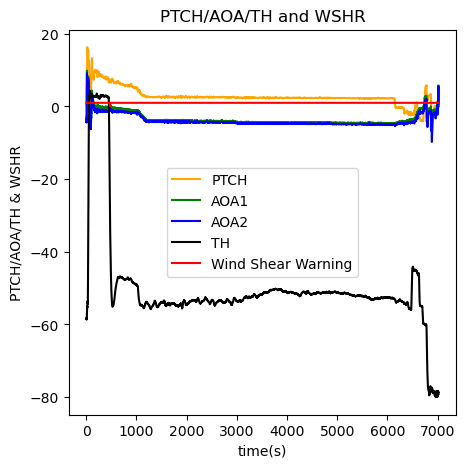

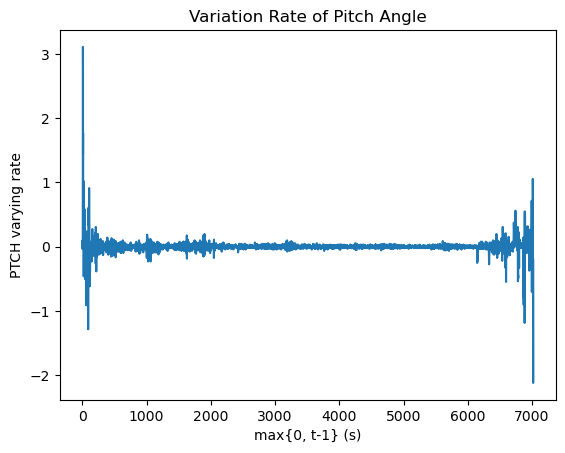

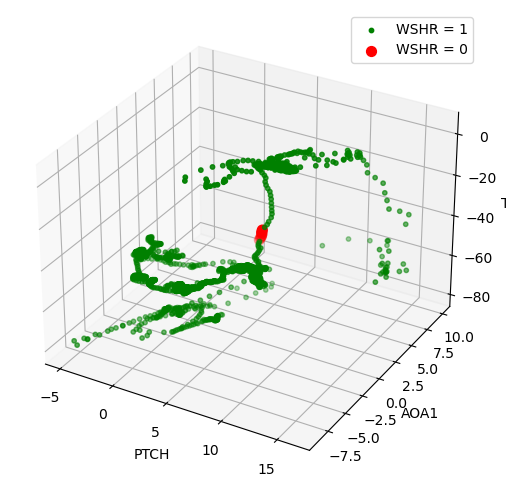

In [83]:
# 判据三：俯仰姿态(PTCH) = 迎角(AOA) + 轨迹角(TH)，变化率不超过5度
variable_list = ['PTCH', 'AOA1', 'AOA2', 'TH'] 
'''
TH, TRK, TRKM可以视为一族变量，趋势极度相似。并不像是民航标准里的flight path angle，应该是“俯视飞机”的视角下的“前进方向角”
AOA1和AOA2能否做平均？
'''

# 构建数据集
X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)
# 读取聚类标签
cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
# 抽取训练集中的有效数据
X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
# X, Y = X[cluster_labels == 3-1], Y[cluster_labels == 3-1]

PTCH_diff = X[1:, 0] - X[:-1, 0]

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('PTCH/AOA/TH & WSHR')
plt.title('PTCH/AOA/TH and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制俯仰姿态的时序差分图
plt.figure()
plt.plot(range(len(PTCH_diff)), PTCH_diff)
plt.title('Variation Rate of Pitch Angle')
plt.xlabel('max{0, t-1} (s)')
plt.ylabel('PTCH varying rate')
plt.show()

# 绘制X的三维散点图
wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 3], c='green', s = 10, label='WSHR = 1')
ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 3], c='red', s = 50, label='WSHR = 0')
ax.set_xlabel(variable_list[0])
ax.set_ylabel(variable_list[1])
ax.set_zlabel(variable_list[3])
ax.legend()
plt.tight_layout()
plt.show()


In [33]:
# 拟合俯仰姿态的计算公式
import numpy as np
from scipy import stats

# 使用 linregress 函数进行线性拟合
slope, residuals, _, _ = np.linalg.lstsq(X[:, 1:], X[:, 0].reshape(-1,1))

# 打印拟合的结果
print("斜率:", slope)
print("残差:", residuals)

斜率: [[ 5.01962978e+00]
 [-5.09809297e+00]
 [ 3.03620153e-03]]
残差: [38251.38718622]


C:\Users\86108\AppData\Local\Temp\ipykernel_56264\4203759152.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, residuals, _, _ = np.linalg.lstsq(X[:, 1:], X[:, 0].reshape(-1,1))


Wind Shear Warns at time [938 939 940 941 942 943]


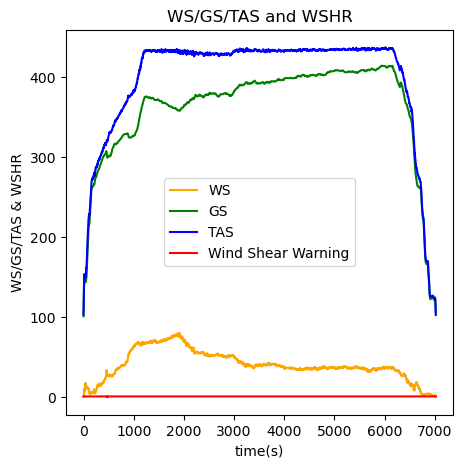

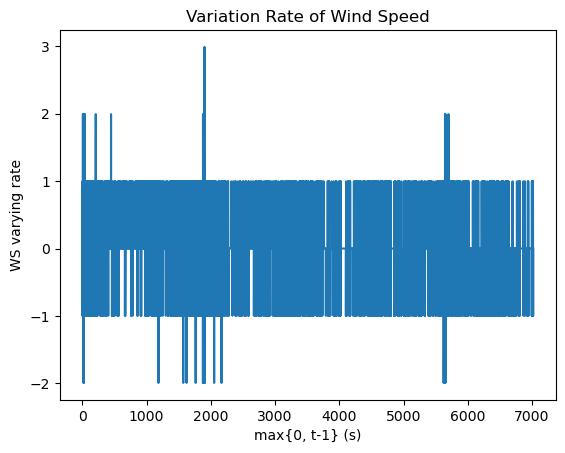

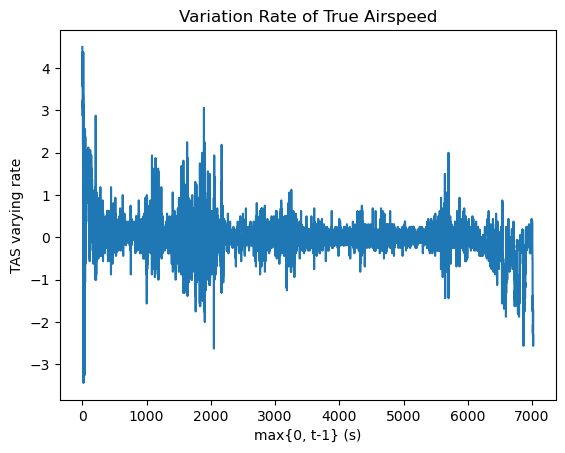

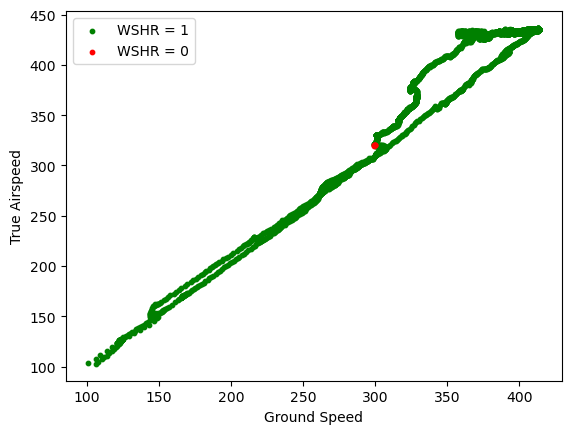

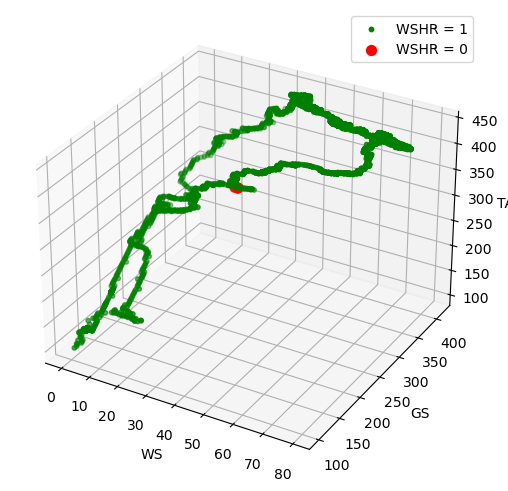

In [24]:
# 判据一：指示空速变化率不超过15节(7.7m/s)
'''
是说风速？空速不是飞机加多少油门决定的吗？
'''
variable_list = ['WS', 'GS', 'TAS']

# 构建数据集
X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)
# 读取聚类标签
cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
# 抽取训练集中的有效数据
X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('WS/GS/TAS & WSHR')
plt.title('WS/GS/TAS and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 绘制风速的时序差分图
WS_diff = X[1:, 0] - X[:-1, 0]
plt.figure()
plt.plot(range(len(WS_diff)), WS_diff)
plt.title('Variation Rate of Wind Speed')
plt.xlabel('max{0, t-1} (s)')
plt.ylabel('WS varying rate')
plt.show()

# 绘制空速的时序差分图
TAS_diff = X[1:, 2] - X[:-1, 2]
plt.figure()
plt.plot(range(len(TAS_diff)), TAS_diff)
plt.title('Variation Rate of True Airspeed')
plt.xlabel('max{0, t-1} (s)')
plt.ylabel('TAS varying rate')
plt.show()

# 绘制二维关联图
plt.figure()
plt.scatter(X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
plt.scatter(X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 10, label='WSHR = 0')
plt.xlabel('Ground Speed')
plt.ylabel('True Airspeed')
plt.legend()
plt.show()

# plt.figure()
# plt.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
# plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 2], c='red', s = 10, label='WSHR = 0')
# plt.xlabel('Wind Speed')
# plt.ylabel('True Airspeed')
# plt.legend()
# plt.show()

# plt.figure()
# plt.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], c='green', s = 10, label='WSHR = 1')
# plt.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], c='red', s = 10, label='WSHR = 0')
# plt.xlabel('Wind Speed')
# plt.ylabel('Ground Speed')
# plt.legend()
# plt.show()

# 绘制X的三维散点图
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
ax.set_xlabel(variable_list[0])
ax.set_ylabel(variable_list[1])
ax.set_zlabel(variable_list[2])
ax.legend()
plt.tight_layout()
plt.show()

Wind Shear Warns at time [938 939 940 941 942 943]


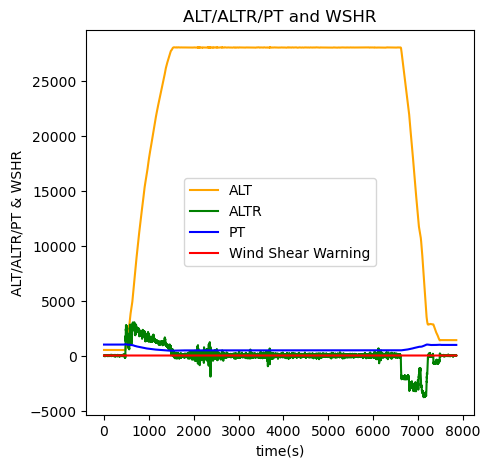

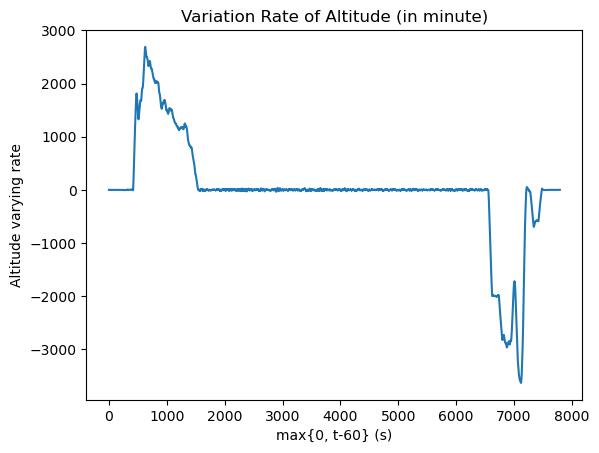

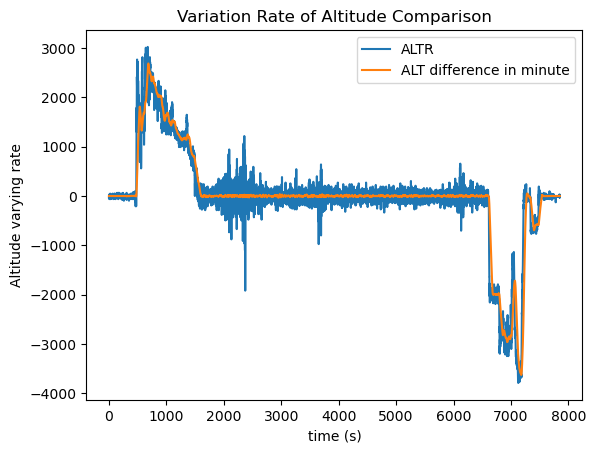

Possible WSHR time: [ 478  479  480  481  482  483  484  485  486  487  488  489  490  491
  492  493  494  495  496  497  498  499  500  501  502  503  504  505
  506  507  508  509  510  512  513  515  521  530  531  532  533  534
  535  536  537  538  539  540  541  542  543  544  558  559  560  561
  562  563  569  571  572  573  574  575  576  577  578  579  580  581
  582  583  584  585  586  611  627  628  629  630  631  632  633  634
  635  636  637  638  639  640  641  642  643  644  645  646  647  648
  650  651  653  654  655  656  657  659  660  661  668  689  690  691
  692  693  696  697  705  706  787  849  918  920  921  922  923  924
  981 1494 1495 1496 1499 1500 3652 6616 6617 6618 6619 6620 6621 6622
 6623 6624 6625 6626 6627 6628 6629 6630 6631 6632 6633 6634 6635 6636
 6637 6638 6639 6640 6641 6642 6643 6644 6645 6646 6647 6648 6649 6650
 6651 6652 6653 6654 6655 6656 6657 6658 6659 6660 6662 6665 6667 6799
 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6

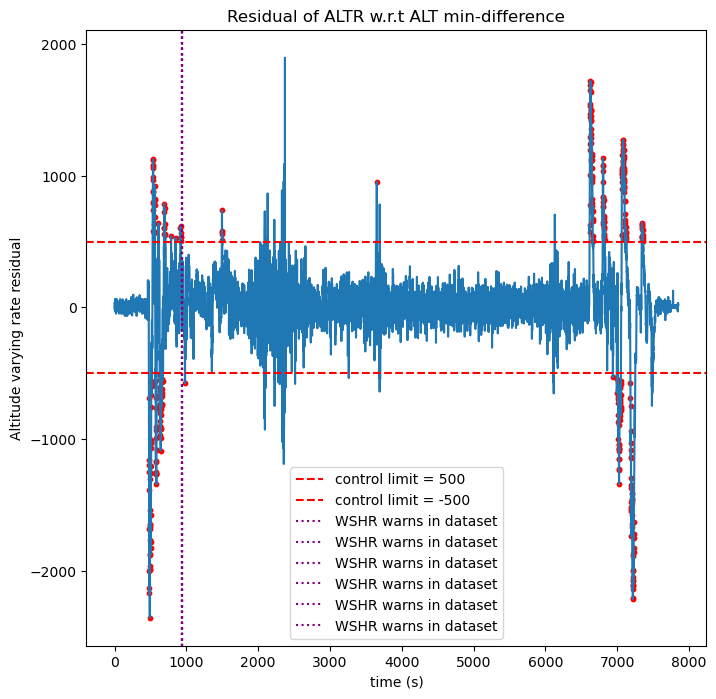

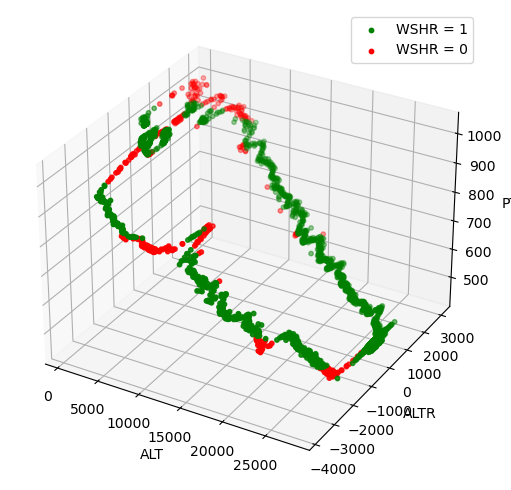

Wind Shear Warns at time [2289 2290 2291 2292 2293 2294 2295]


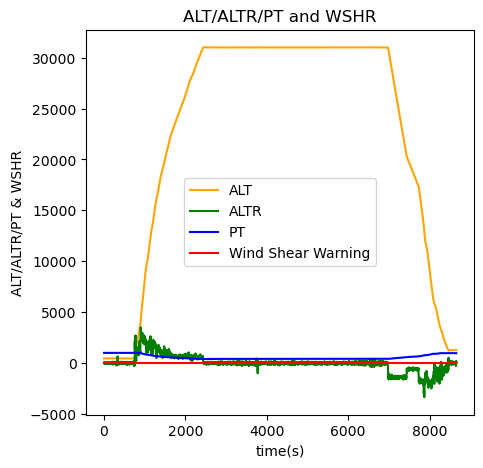

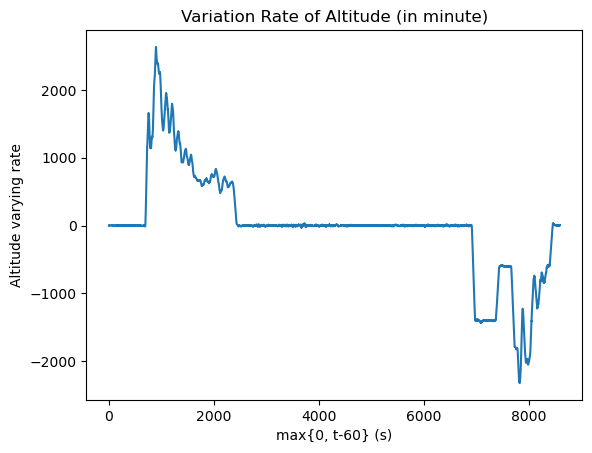

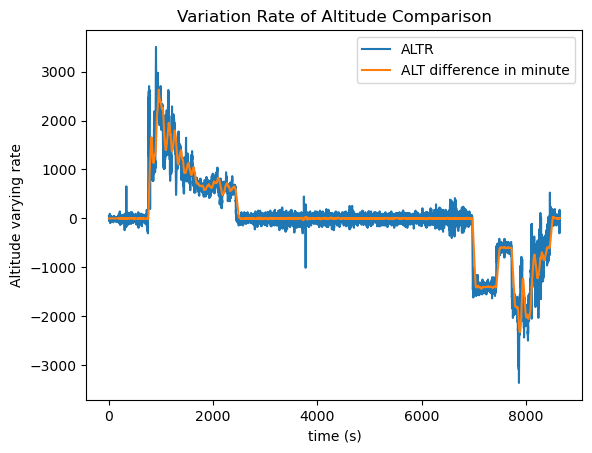

Possible WSHR time: [ 755  756  757  758  759  760  761  762  763  764  765  766  767  768
  769  770  771  772  773  774  775  776  777  778  779  780  781  782
  783  789  790  792  813  829  830  831  832  864  865  866  867  868
  869  870  871  872  873  874  875  896  897  898  899  900  901  902
  903  904  905  906  907  908  909  910  911  912  913  914  915  916
  917  919  926  932  935  936  938  939  941  971  972 1036 1037 1038
 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052
 1053 1054 1055 1056 1057 1058 1059 1060 1064 1067 1070 1084 1085 1089
 1091 1096 1098 1101 1104 1108 1133 1138 1139 1140 1141 1144 1148 1149
 1151 1157 1158 1167 1168 1169 1170 1171 1172 1173 1174 1175 1179 1185
 1186 1189 1191 1193 1194 1196 1205 1210 1211 1213 1215 1218 1227 1238
 1239 1281 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294
 1295 1296 1335 1338 1341 1392 1437 1478 1479 1480 1481 6977 6978 6979
 6980 6981 6982 6983 6984 6985 6986 6987 6988 6989 6990 6

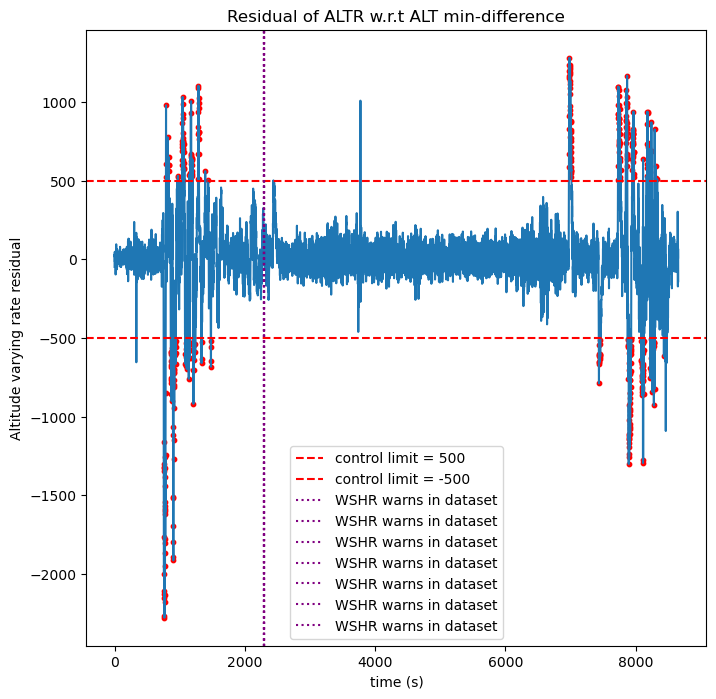

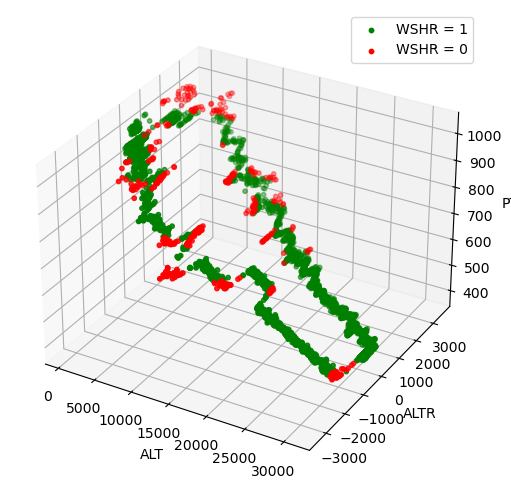

In [22]:
# 判据二：垂直升降率不超过500英尺/分钟 (152.4m)
'''
民航客机的巡航高度约为10000米（33000英尺），推断ALT和ALTR记录的量纲为英尺
'''

variable_list = ['ALT', 'ALTR', 'PT']
'''
ALTR实质是ALT的步差，这里用秒差，但是单位转化成了英尺/分钟（乘了60）
'''

def verticalSpeed(X, Y):

    # 绘制X的时间变化
    plt.figure(figsize=(5,5))
    color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
    for i, var_name in enumerate(variable_list):
        plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
    plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
    plt.xlabel('time(s)')
    plt.ylabel('ALT/ALTR/PT & WSHR')
    plt.title('ALT/ALTR/PT and WSHR')
    plt.legend()
    # if np.std(X[:, 2]) > 1e-1:
    #     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
    plt.show()

    # ALT_diff = X[1:, 0] - X[:-1, 0]
    # plt.figure()
    # plt.plot(range(len(ALT_diff)), ALT_diff)
    # # plt.xlim(1100, 6000)
    # # plt.ylim(-100,100)
    # plt.title('Variation Rate of Altitude (in second)')
    # plt.xlabel('max{0, t-1} (s)')
    # plt.ylabel('Altitude varying rate')
    # plt.show()

    # 以60s为滑动窗口，计算海拔的变化值
    ALT_diff = X[60:, 0] - X[:-60, 0]
    plt.figure()
    plt.plot(range(len(ALT_diff)), ALT_diff)
    # plt.xlim(1100, 6000)
    # plt.ylim(-100,100)
    plt.title('Variation Rate of Altitude (in minute)')
    plt.xlabel('max{0, t-60} (s)')
    plt.ylabel('Altitude varying rate')
    plt.show()

    # 比较ALTR和分钟滑动的ALT
    '''
    ALTR相当于在这一秒预测接下来一分钟的升降率（基于下一秒的步差），ALT分钟滑动相当于计算接下来一分钟实际发生的升降率
    前者反映瞬间的速度方向，后者反映一分钟内的平均位移水平（是计划上升还是巡航还是计划下降）
    二者的差分反映这一秒的升降率是否在计划内
    滑动的窗口大小实际上可以调节，但是考虑到单位是英尺/分钟，选取了1分钟做窗口
    '''
    ALT_diff_extend = [0 if i-60 < 0 else ALT_diff[i-60] for i in range(len(X[:, 1]))]
    # ALT_diff_extend = [0 if i-1 < 0 else ALT_diff[i-1]*60 for i in range(len(X[:, 1]))]
    ALTR_residual = np.array(ALT_diff_extend) - X[:, 1]
    plt.figure()
    plt.plot(range(len(X[:, 1])), X[:, 1], label='ALTR')
    plt.plot(range(len(ALT_diff_extend)), ALT_diff_extend, label='ALT difference in minute')
    # plt.plot(range(len(ALTR_residual)), ALTR_residual, label='ALTR residual w.r.t ALT min-differ')
    plt.title('Variation Rate of Altitude Comparison')
    plt.xlabel('time (s)')
    plt.ylabel('Altitude varying rate')
    plt.legend()
    plt.show()

    # 计算ALTR相较于分钟滑动ALT的残差
    ALT_stable_time = np.where(np.abs(ALT_diff) <= 30)[0]
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(np.min(ALT_stable_time), np.max(ALT_stable_time))
    ALTR_residual = np.array(ALT_diff_extend) - X[:, 1]
    ALTR_overlimit = [ALTR_residual[i] if abs(ALTR_residual[i])>500 and i not in ALT_stable_time else None for i in range(len(ALTR_residual))]
    print(f"Possible WSHR time: {np.where(np.array(ALTR_overlimit) != None)[0]}")
    plt.figure(figsize=(8, 8))
    plt.plot(range(len(ALTR_residual)), ALTR_residual)
    plt.scatter(range(len(ALTR_overlimit)), ALTR_overlimit, c='red', s=10)
    for i, value in enumerate(ALTR_overlimit):
        if value != None:
            plt.axvline(x=i, ymin=np.min(ALTR_residual), ymax=np.min(ALTR_residual)+50, color='purple', linestyle='dotted')
    plt.axhline(y=500, color='r', linestyle='--', label='control limit = 500') 
    plt.axhline(y=-500, color='r', linestyle='--', label='control limit = -500') 
    for t in wshr_class_idx[0]:
        plt.axvline(x=t, color = 'purple', linestyle='dotted', label='WSHR warns in dataset')
    plt.title('Residual of ALTR w.r.t ALT min-difference')
    plt.xlabel('time (s)')
    plt.ylabel('Altitude varying rate residual')
    plt.legend()
    plt.show()

    # 绘制X的三维散点图
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = 10, label='WSHR = 1')
    # ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = 50, label='WSHR = 0')
    ax.scatter(X[np.where(np.array(ALTR_overlimit) == None)[0], 0], X[np.where(np.array(ALTR_overlimit) == None)[0], 1], X[np.where(np.array(ALTR_overlimit) == None)[0], 2], c='green', s = 10, label='WSHR = 1')
    ax.scatter(X[np.where(np.array(ALTR_overlimit) != None)[0], 0], X[np.where(np.array(ALTR_overlimit) != None)[0], 1], X[np.where(np.array(ALTR_overlimit) != None)[0], 2], c='red', s = 10, label='WSHR = 0')
    ax.set_xlabel(variable_list[0])
    ax.set_ylabel(variable_list[1])
    ax.set_zlabel(variable_list[2])
    ax.legend()
    plt.tight_layout()
    plt.show()

# 构建数据集
for mat_idx in [2, 8]:
    X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[mat_idx], variable_list, normalized=False)
    # # 读取聚类标签
    # cluster_labels = np.load('../result/variable_cluster/DBSCAN/cluster_labels_e[3][2].npy')
    # # 抽取训练集中的有效数据
    # X, Y = X[cluster_labels == 2-1], Y[cluster_labels == 2-1]
    verticalSpeed(X, Y)


Wind Shear Warns at time [938 939 940 941 942 943]


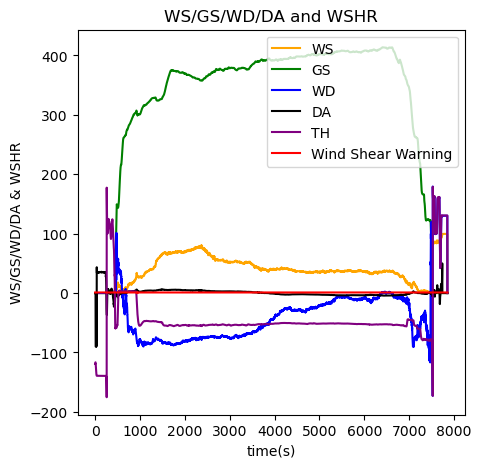

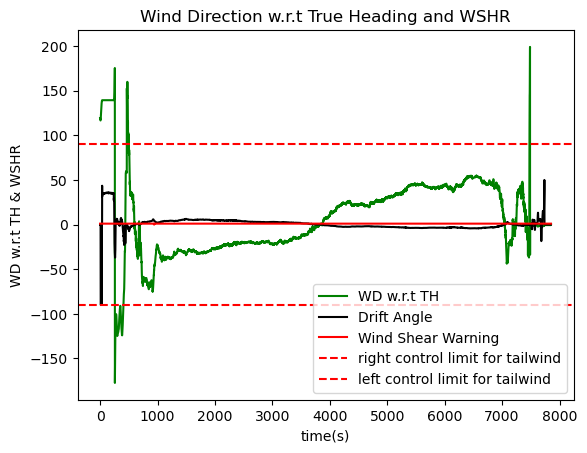

178.92898559570312 -175.3530429091797


In [18]:
# 验证航行速度三角形
variable_list = ['WS', 'GS', 'WD', 'DA', 'TH']

X, Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2], variable_list, normalized=False)

# 绘制X的时间变化
plt.figure(figsize=(5,5))
color_list = ['orange', 'green', 'blue', 'black', 'purple', 'pink']
for i, var_name in enumerate(variable_list):
    plt.plot(range(len(Y)), X[:, i], c=color_list[i], label=var_name)
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.xlabel('time(s)')
plt.ylabel('WS/GS/WD/DA & WSHR')
plt.title('WS/GS/WD/DA and WSHR')
plt.legend()
# if np.std(X[:, 2]) > 1e-1:
#     plt.savefig(f"../result/wshr_classify/supervised/SVM/figures_WS&WD&TAS/{work_mat_name}.png")
plt.show()

# 计算WD相对于TH坐标系的角度，以判断逆风/顺风
WD_wrtTH = X[:, 2] - X[:, 4]
plt.figure()
plt.plot(range(len(Y)), WD_wrtTH, c='green', label='WD w.r.t TH')
plt.plot(range(len(Y)), X[:, 3], c='black', label='Drift Angle')
plt.plot(range(len(Y)), Y, c='red', label='Wind Shear Warning')
plt.axhline(y=90, c='r', linestyle='--', label='right control limit for tailwind')
plt.axhline(y=-90, c='r', linestyle='--', label='left control limit for tailwind')
# plt.xlim(900, 950)
plt.xlabel('time(s)')
plt.ylabel('WD w.r.t TH & WSHR')
plt.title('Wind Direction w.r.t True Heading and WSHR')
plt.legend()
plt.show()


# 按照航行速度三角形，基于GS、WD和DA计算WS
WS_estimate = []
print(np.max(X[:, 4]), np.min(X[:, 4]))
